In [4]:
import bayesflow as bf
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import torch
from torch.distributions import Normal, Independent,InverseGamma


/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [119]:
# 定义先验分布
def prior_fun(batch_size=1):
    #  N(mean, stddev)
    mean, stddev = 0.0, 1.0
    miu_dist = tfp.distributions.Normal(mean, stddev)
    miu_samples = tf.cast(miu_dist.sample(batch_size), dtype=tf.float32)

    #  InverseGamma(alpha, beta)
    alpha, beta = 2.0, 1.0
    sigma2_dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)
    sigma2_samples = tf.cast(sigma2_dist.sample(batch_size), dtype=tf.float32)
    # (batch_size, 2) 
    return tf.concat([miu_samples[:, None], sigma2_samples[:, None]], axis=-1)


def likelihood_fun(params, n_obs=1000):
    miu = params[:, 0]  #  miu
    sigma2 = params[:, 1]  #  sigma^2
    return tf.random.normal(
        shape=(params.shape[0], n_obs, 1),
        mean=miu[:, None],
        stddev=tf.sqrt(sigma2)[:, None]
    )

In [137]:

prior = bf.simulation.Prior(prior_fun=prior_fun)
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

summary_net = bf.networks.DeepSet(summary_dim=10)

inference_net = bf.networks.InvertibleNetwork(
    num_params=2,
    num_coupling_layers=4,
)


amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

# configurator
def custom_configurator(simulation_outputs):
    prior_draws = simulation_outputs['prior_draws']
    transformed_sigma2 = tf.math.log(prior_draws[:,:,1:2])

    transformed_params = tf.concat([prior_draws[:,:,0:1], transformed_sigma2], axis=-1)

    configured_outputs = {
        'parameters': transformed_params,          
        'summary_conditions': simulation_outputs['sim_data'],  
        'direct_conditions': None
    }
    return configured_outputs
 
# 定义 Trainer 并使用自定义 configurator
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=custom_configurator 
)

# 开始训练
history = trainer.train_online(
    epochs=5,
    iterations_per_epoch=500,
    batch_size=32,
    validation_sims=200
)


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 500/500 [01:12<00:00,  6.94it/s, Epoch: 1, Iter: 500,Loss: -1.356,W.Decay: 0.159,Avg.Loss: 0.591,Avg.W.Decay: 0.167,LR: 4.52E-04]
INFO:root:Validation, Epoch: 1, Loss: -1.326
Training epoch 2: 100%|██████████| 500/500 [01:09<00:00,  7.21it/s, Epoch: 2, Iter: 500,Loss: -2.836,W.Decay: 0.153,Avg.Loss: -2.046,Avg.W.Decay: 0.156,LR: 3.28E-04]
INFO:r

In [148]:

n_obs = 1000  
true_miu = 0 
true_sigma = 0.3  
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  #  NumPy 
obs_data = obs_data[np.newaxis, :, :]  # (1, n_obs, 1)

posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=1000)

In [149]:
posterior_samples

array([[ 0.3284531 , -2.6074123 ],
       [ 0.3119891 , -2.4402015 ],
       [ 0.01688483, -2.5661292 ],
       ...,
       [-0.08070169, -2.6725516 ],
       [ 0.03721499, -2.581575  ],
       [-0.15681767, -2.6155918 ]], dtype=float32)

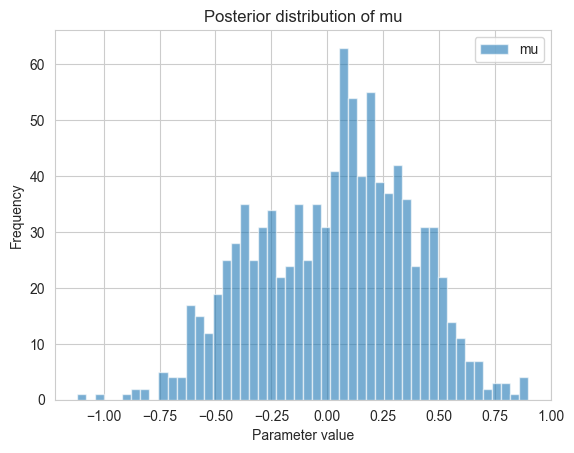

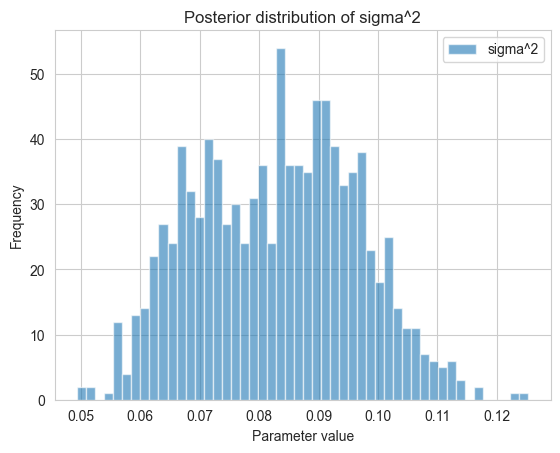

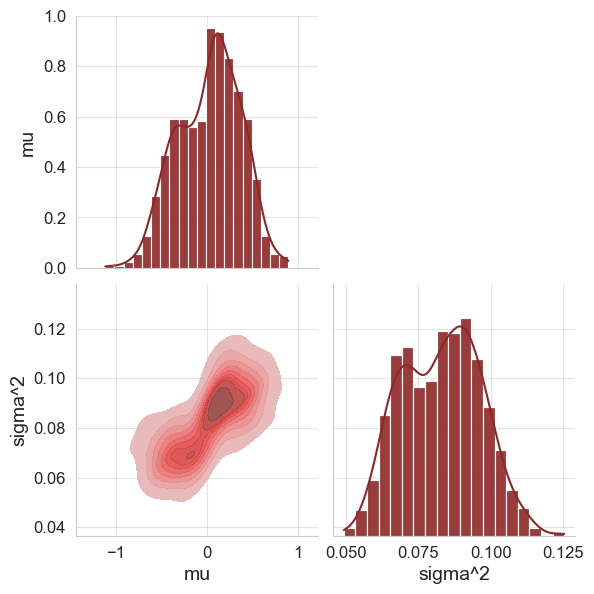

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 4. 可视化后验分布
# 参数名称
param_names = ["mu", "sigma^2"]

posterior_samples[:, 1]= np.exp(posterior_samples[:, 1])

# 绘制每个参数的后验分布直方图
for i in range(posterior_samples.shape[1]):  # 遍历 mu 和 sigma^2
    plt.hist(posterior_samples[:, i], bins=50, alpha=0.6, label=f"{param_names[i]}")
    plt.xlabel("Parameter value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Posterior distribution of {param_names[i]}")
    plt.show()

# 5. 可视化参数的二维联合分布
# 使用诊断工具绘制联合分布
f = bf.diagnostics.plot_posterior_2d(posterior_samples, param_names=param_names)


In [151]:
posterior_samples

array([[ 0.3284531 ,  0.07372507],
       [ 0.3119891 ,  0.08714329],
       [ 0.01688483,  0.07683238],
       ...,
       [-0.08070169,  0.06907574],
       [ 0.03721499,  0.07565476],
       [-0.15681767,  0.07312451]], dtype=float32)

In [152]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差
alpha_0 = 2
beta_0 = 1  # 先验比例参数

# 样本均值和样本数量
Y_mean = np.mean(Z)  # 样本均值
n = n_obs  # 样本数量

# 计算样本总方差
variance = np.sum((Z - Y_mean) ** 2)  # 总变异

kappa_0 = 1
kappa_n = kappa_0 + n

# 后验参数计算
# sigma^2 的后验
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# mu 的后验
sigma_poster_sq = sigma_0_sq / (kappa_0+n)  # 后验方差
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # 后验均值

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 502.0
Posterior beta: 47.546455051768355
Posterior mu (mean): -0.003818526294651803
Posterior sigma^2 (variance): 0.000999000999000999


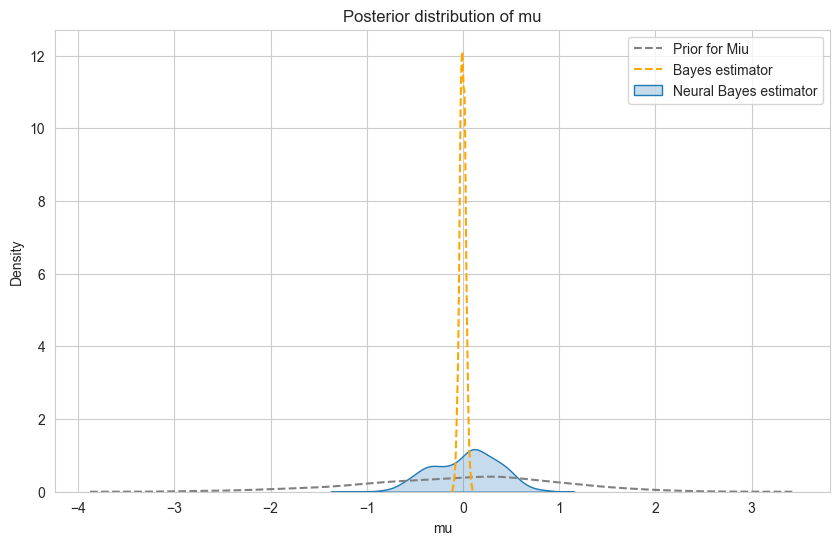

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 设置 Prior 分布的参数
mu_prior = 0  # 均值
sigma_prior = 1  # 标准差
# 定义后验分布
dist = tfp.distributions.Normal(loc=0, scale=1)

# 从后验分布中采样
prior_samples = dist.sample(1000).numpy()

sns.kdeplot(prior_samples, label="Prior for Miu", color="grey", linestyle="--")
sigma_poster = np.sqrt(sigma_poster_sq)

# 定义后验分布
dist = tfp.distributions.Normal(loc=mu_poster, scale=sigma_poster)
# 从后验分布中采样
reference = dist.sample(1000).numpy()
sns.kdeplot(reference, label="Bayes estimator",color = "orange", linestyle="--")

# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[0])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[0]}")
plt.legend()
plt.show()

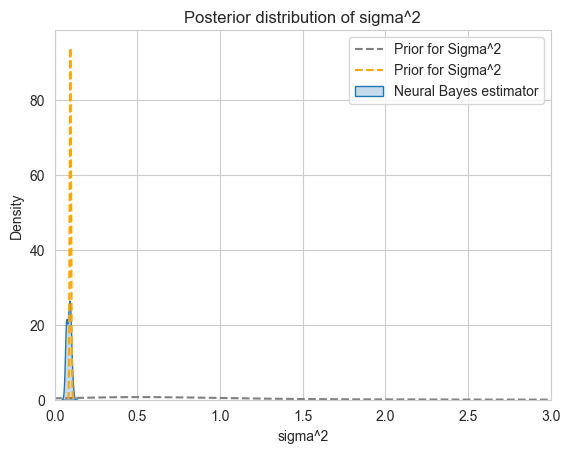

In [155]:
# sigma_poster_samples = np.exp(posterior_samples[:, 1])

# 定义后验分布
dist = tfp.distributions.InverseGamma(concentration=2, scale=1)
prior_samples = dist.sample(1000).numpy()
sns.kdeplot(prior_samples, label="Prior for Sigma^2", color="grey", linestyle="--")

dist = tfp.distributions.InverseGamma(concentration=alpha_poster, scale=beta_poster)
poster_samples = dist.sample(1000).numpy()
sns.kdeplot(poster_samples, label="Prior for Sigma^2", color="orange", linestyle="--")

# 设置 x 轴范围
plt.xlim(0, 3)

param_names = ["mu", "sigma^2"]
sns.kdeplot(posterior_samples[:, 1], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[1])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[1]}")
plt.legend()
plt.show()

In [132]:

prior = bf.simulation.Prior(prior_fun=prior_fun)
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

# 定义总结网络
summary_net = bf.networks.DeepSet(summary_dim=10)

inference_net = bf.networks.InvertibleNetwork(
    num_params=1, # need change
    num_coupling_layers=4,
)

amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

# configurator
def custom_configurator(simulation_outputs):
    prior_draws = simulation_outputs['prior_draws']
    configured_outputs = {
        'parameters': prior_draws.astype(np.float32), 
        'summary_conditions': simulation_outputs['sim_data'].astype(np.float32), 
    }
    return configured_outputs

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=custom_configurator
)

# 开始训练
history = trainer.train_online(
    epochs=1,
    iterations_per_epoch=500,
    batch_size=32,
    validation_sims=200
)


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 200 simulations for validation.
Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104b00550>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thre

In [87]:
# 1. 生成真实数据
# 假设真实数据从 N(0, 1) 分布生成
n_obs = 1000  # 样本数量
true_miu = 10  # 真实均值
true_sigma = 0.3  # 真实标准差
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # 如果是 PyTorch 张量，转换为 NumPy 数组
obs_data = obs_data[np.newaxis, :, :]  # 调整形状为 (1, n_obs, 1)

posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=1000)

In [88]:
posterior_samples

array([[ 9.541505 ],
       [10.104842 ],
       [10.068947 ],
       [ 9.838695 ],
       [10.2282   ],
       [10.089205 ],
       [ 8.565814 ],
       [ 9.768    ],
       [10.500083 ],
       [ 9.659709 ],
       [10.018328 ],
       [ 9.503186 ],
       [ 9.82938  ],
       [ 9.948931 ],
       [ 9.451259 ],
       [ 9.666302 ],
       [ 9.519944 ],
       [10.44567  ],
       [10.058433 ],
       [ 9.856458 ],
       [10.086935 ],
       [10.276283 ],
       [ 9.871527 ],
       [10.224292 ],
       [10.327405 ],
       [ 9.928277 ],
       [10.238192 ],
       [10.192331 ],
       [ 9.704435 ],
       [ 9.496735 ],
       [ 9.135515 ],
       [ 9.470477 ],
       [ 9.728517 ],
       [10.504771 ],
       [10.117803 ],
       [10.137851 ],
       [10.052811 ],
       [ 9.629124 ],
       [ 9.492399 ],
       [ 9.788741 ],
       [10.5301895],
       [10.4281025],
       [10.23922  ],
       [10.338771 ],
       [10.040213 ],
       [10.230165 ],
       [ 9.527604 ],
       [10.37

In [89]:
test_output = model(batch_size=5) 
configured_output = custom_configurator(test_output)

print("Original prior_draws:", test_output['prior_draws'])
print("Configured parameters:", configured_output['parameters'])
print("Shape of configured parameters:", configured_output['parameters'].shape)

Original prior_draws: [[[11.818282    0.48411348]]

 [[ 8.7842245   0.56583726]]

 [[10.511306    0.4514487 ]]

 [[ 9.842771    3.0770793 ]]

 [[10.244902    1.0144949 ]]]
Configured parameters: [[[11.818282 ]]

 [[ 8.7842245]]

 [[10.511306 ]]

 [[ 9.842771 ]]

 [[10.244902 ]]]
Shape of configured parameters: (5, 1, 1)
